# HSCT survival: Kullback-Leibler divergence

## Notebook set-up

In [1]:
import pickle
import numpy as np
# import pandas as pd
# import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler

import configuration as config
# import functions.helper as helper_funcs
# import functions.plotting as plot_funcs

notebook_num='02.3'
gpu=0

# Data files
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'
coxph_survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'
weibullaft_survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'
kld_features=f'{config.PROCESSED_DATA}/{notebook_num}-kld_survival.pkl'

## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Load one of the datasets
with open(datasets['Continuous target encoded'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Load Cox Proportional Hazard model features
with open(coxph_survival_file, 'rb') as input_file:
    coxph_features=pickle.load(input_file)

print('\nCox PH features:\n')
for key, value in coxph_features.items():
    print(f' {key}: {type(value)}')

# Load Weibull Accelerated Failure Time model features
with open(weibullaft_survival_file, 'rb') as input_file:
    weibullaft_features=pickle.load(input_file)

print('\nWeibull AFT features:\n')
for key, value in weibullaft_features.items():
    print(f' {key}: {type(value)}')

Data dictionary contains:

 Training features: <class 'pandas.core.frame.DataFrame'>
 Training labels: <class 'pandas.core.frame.DataFrame'>
 Training IDs: <class 'list'>
 Training race group: <class 'list'>
 Testing features: <class 'pandas.core.frame.DataFrame'>
 Testing labels: <class 'pandas.core.frame.DataFrame'>
 Testing IDs: <class 'list'>
 Testing race group: <class 'list'>

Cox PH features:

 Training survival: <class 'list'>
 Training partial hazard: <class 'list'>
 Testing survival: <class 'list'>
 Testing partial hazard: <class 'list'>

Weibull AFT features:

 Training survival: <class 'list'>
 Training expectation: <class 'list'>
 Testing survival: <class 'list'>
 Testing expectation: <class 'list'>


## 2. Data preparation

In [3]:
input_features=['CoxPH survival','CoxPH partial hazard','WeibullAFT survival','WeibullAFT expectation']

training_df=data_dict['Training labels']
training_df['CoxPH survival']=coxph_features['Training survival']
training_df['CoxPH partial hazard']=np.log(coxph_features['Training partial hazard'])
training_df['WeibullAFT survival']=weibullaft_features['Training survival']
training_df['WeibullAFT expectation']=np.log(weibullaft_features['Training expectation'])

testing_df=data_dict['Testing labels']
testing_df['CoxPH survival']=coxph_features['Testing survival']
testing_df['CoxPH partial hazard']=np.log(coxph_features['Testing partial hazard'])
testing_df['WeibullAFT survival']=weibullaft_features['Testing survival']
testing_df['WeibullAFT expectation']=np.log(weibullaft_features['Testing expectation'])

scaler=StandardScaler()
scaler.fit(training_df[input_features])
training_df[input_features]=scaler.transform(training_df[input_features])
testing_df[input_features]=scaler.transform(testing_df[input_features])

efs_one=training_df[training_df['efs'] == 0]
efs_zero=training_df[training_df['efs'] == 1]

training_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
efs,20160.0,5.390873e-01,0.498482,0.000000,0.000000,1.000000,1.000000,1.000000
efs_time,20160.0,2.329701e+01,24.924465,0.333000,5.625500,9.826000,35.183500,156.819000
CoxPH survival,20160.0,1.064404e-16,1.000025,-2.389052,-0.706981,-0.106571,0.573035,2.525002
CoxPH partial hazard,20160.0,1.665335e-17,1.000025,-3.677598,-0.424942,0.164732,0.655778,2.972068
WeibullAFT survival,20160.0,3.965082e-17,1.000025,-0.890911,-0.693222,-0.392147,0.259939,3.733253
WeibullAFT expectation,20160.0,4.236470e-16,1.000025,-2.913624,-0.662215,-0.181390,0.450361,3.714172


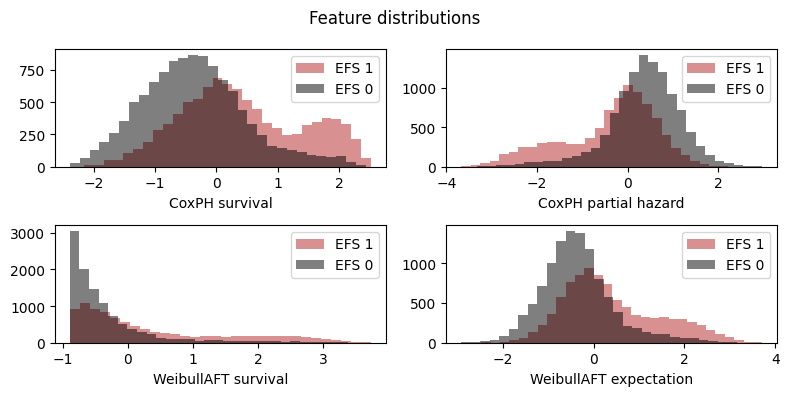

In [4]:
fig, axs=plt.subplots(2,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Feature distributions')

for i, feature in enumerate(input_features):
    axs[i].hist(efs_one[feature], bins=30, color='firebrick', alpha=0.5, label='EFS 1')
    axs[i].hist(efs_zero[feature], bins=30, color='black', alpha=0.5, label='EFS 0')
    axs[i].set_xlabel(feature)
    axs[i].legend(loc='best')

fig.tight_layout()
fig.show()

### 3. Kernel density estimation

In [5]:
kdes={}

for feature in input_features:

    feature_min=min(training_df[feature])
    feature_max=max(training_df[feature])
    feature_range=feature_max-feature_min
    padding=feature_range*0.05
    x=np.linspace(feature_min-padding, feature_max+padding)

    efs_zero_kde=gaussian_kde(
        efs_zero[feature].values, 
        bw_method='silverman'
    )

    efs_one_kde=gaussian_kde(
        efs_one[feature].values, 
        bw_method='silverman'
    )

    kdes[feature]={
        'x': x,
        'EFS one': efs_one_kde(x),
        'EFS zero': efs_zero_kde(x)
    }


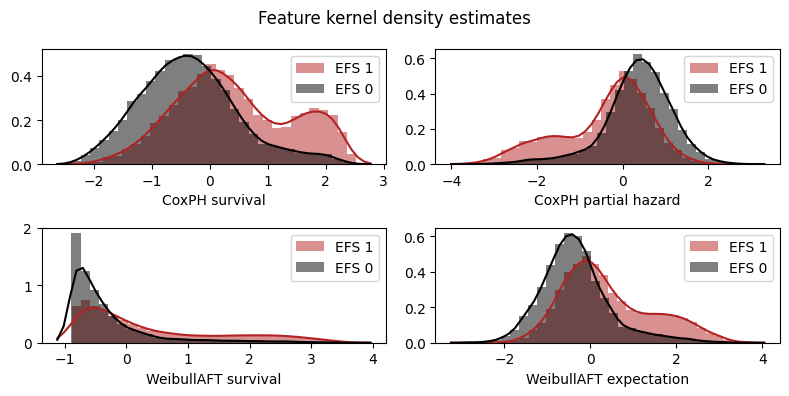

In [6]:
fig, axs=plt.subplots(2,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Feature kernel density estimates')

for i, feature in enumerate(input_features):
    axs[i].hist(efs_one[feature], bins=30, density=True, color='firebrick', alpha=0.5, label='EFS 1')
    axs[i].hist(efs_zero[feature], bins=30, density=True, color='black', alpha=0.5, label='EFS 0')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS one'], color='firebrick')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS zero'], color='black')
    axs[i].set_xlabel(feature)
    axs[i].legend(loc='best')

fig.tight_layout()
fig.show()

### 4. Kullback-Leibler divergence

In [7]:
for feature in input_features:

    # Convert inputs to numpy
    p=np.asarray(kdes[feature]['EFS one'])
    q=np.asarray(kdes[feature]['EFS zero'])

    # Set handling for overflows/underflows - just ignore. We will handle infinite
    # or nan values later by just filtering them out.
    with np.errstate(over='ignore', under='ignore', divide='ignore', invalid='ignore'):
        kld_values=p * np.log2(p/q)

    kdes[feature]['KLD']=kld_values

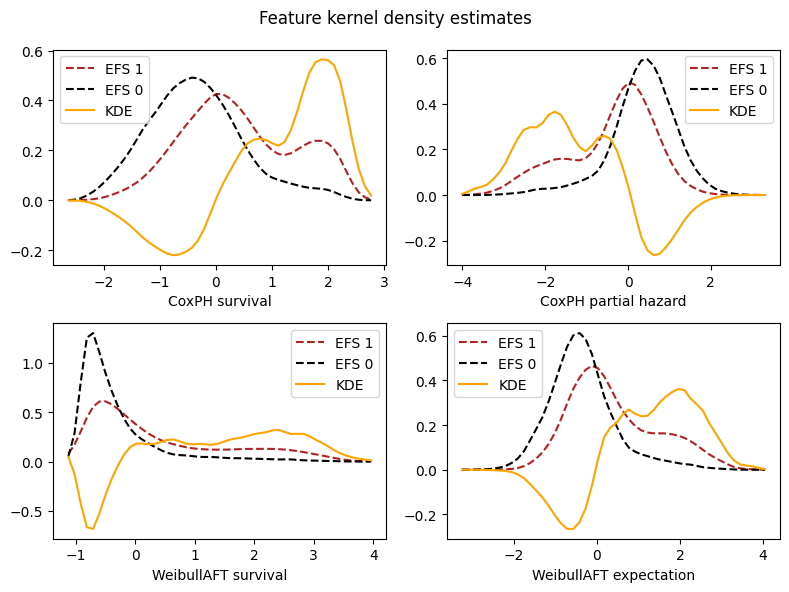

In [12]:
fig, axs=plt.subplots(2,2, figsize=(8,6))
axs=axs.flatten()

fig.suptitle('Feature kernel density estimates')

for i, feature in enumerate(input_features):
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS one'], linestyle='dashed', color='firebrick', label='EFS 1')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS zero'], linestyle='dashed', color='black', label='EFS 0')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['KLD'], color='orange', label='KDE')
    axs[i].set_xlabel(feature)
    axs[i].legend(loc='best')

fig.tight_layout()
fig.show()